The duration of a match helps us infer the play style of the players of a region. Shorter match times may point at a more aggressive compared to a more calculated and slower play style. Different regions of the world differ in this metric in a lot of online games.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [16]:
matches = pd.read_csv('datasets/dota-2-matches/match.csv')

matches.head()

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156


In [17]:
# Convert duration from seconds to minutes for readability
matches['duration'] = matches['duration'] / 60

# Convert Unix timestamp to datetime
matches['date'] = pd.to_datetime(matches['start_time'], unit = 's')

# Merge the clusters table into the matches
clusters = pd.read_csv('datasets/dota-2-matches/cluster_regions.csv')
matches =  matches.merge(clusters, on = 'cluster', how = 'left')
matches = matches[['duration', 'game_mode', 'date', 'region']]

matches.head()

,duration,game_mode,date,region
0,39.583333,22,2015-11-05 19:01:52,SINGAPORE
1,43.033333,22,2015-11-05 19:51:18,SINGAPORE
2,45.266667,22,2015-11-05 23:03:06,EUROPE
3,51.416667,22,2015-11-05 23:22:03,AUSTRIA
4,31.450000,22,2015-11-06 07:53:05,SINGAPORE


Text(0.5, 1.0, 'Game duration, Median: 40.3')

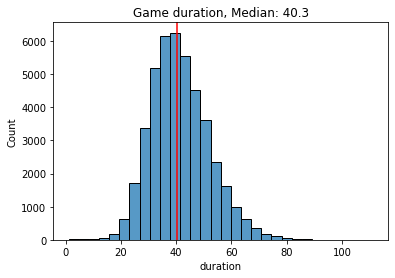

In [108]:
sns.histplot(data=matches, x='duration', bins=30)
median_duration = matches['duration'].median()
plt.axvline(x=median_duration, color='red')
plt.title(f"Game duration, Median: {median_duration}")

Text(0.5, 1.0, 'Player concentration across regions')

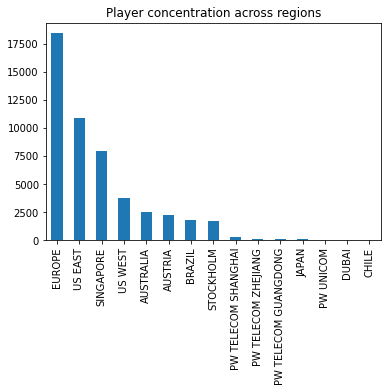

In [20]:
matches['region'].value_counts().plot(kind = 'bar').set_title('Player concentration across regions')

Selecting the top regions for analysis

In [23]:
# Drop any region outside of the ones we are interested in
regions_to_keep = ['EUROPE', 'US EAST', 'SINGAPORE', 'US WEST', 'AUSTRALIA']

matches.drop(matches[ ~matches['region'].isin(regions_to_keep)].index, inplace = True)

<AxesSubplot:xlabel='region', ylabel='duration'>

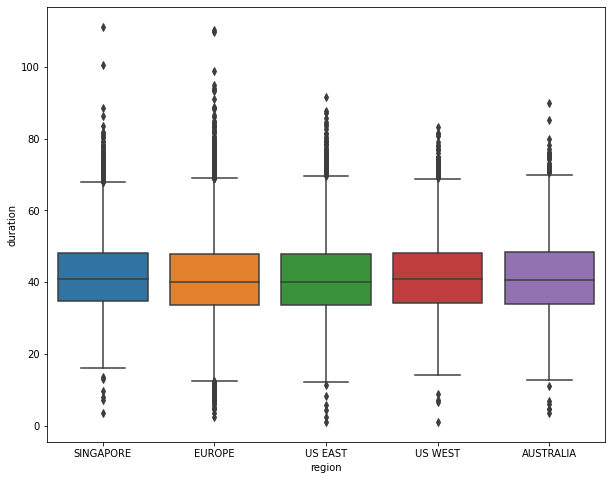

In [102]:
#matches.boxplot('duration', by = 'region')
plt.figure(figsize=(10,8))
sns.boxplot(x = 'region', y = 'duration', data=matches)

Match Duration Globally


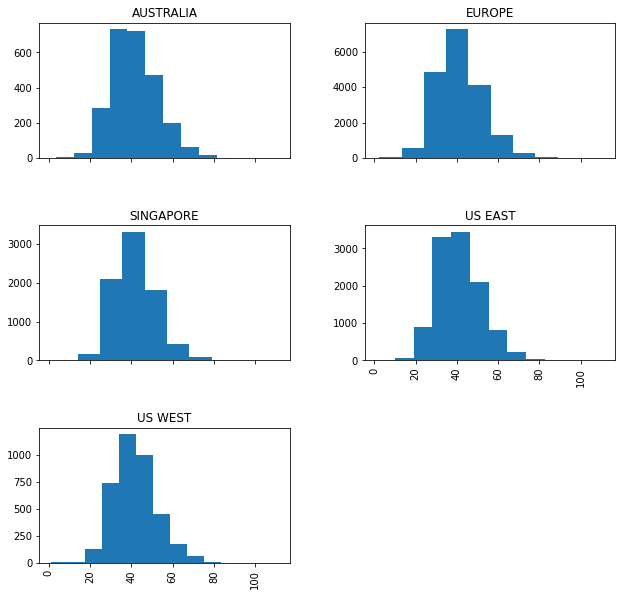

In [101]:
print('Match Duration Globally')

matches['duration'].hist(by = matches['region'], figsize = (10,10), sharex=True)
plt.show()

We can see minor differences in the distribution of durations across regions. To test the statistical significance of these results, we can perform a pairwise t-test for the following hypothesis:

$H_o$: The duration distribution means across regions are the same

$H_a$: The durations across regions are different

In [92]:
import itertools

durations_by_region = []
for region in regions_to_keep:
    durations_by_region.append(matches[matches['region'] == region]['duration'])

regions = itertools.permutations(regions_to_keep, 2)

regions_duration = pd.DataFrame(columns=['region_1', 'region_2', 't_statistic', 'p_value'])

for r1, r2 in regions:
    max_len = min(len(matches[matches['region'] == r1]), len(matches[matches['region'] == r2]))
    T, p = stats.ttest_ind(matches[matches['region'] == r1]['duration'][:max_len], 
                           matches[matches['region'] == r2]['duration'][:max_len], equal_var=False)
    regions_duration.loc[len(regions_duration.index)] = [r1, r2, T, p]

Get regions with statistically significant mean values

In [93]:
regions_duration[regions_duration['p_value'] > 0.05]

,region_1,region_2,t_statistic,p_value
0,EUROPE,US EAST,-1.906170,0.056641
3,EUROPE,AUSTRALIA,-1.875495,0.060783
4,US EAST,EUROPE,1.906170,0.056641
7,US EAST,AUSTRALIA,-1.726790,0.084267
10,SINGAPORE,US WEST,-0.061228,0.951179
11,SINGAPORE,AUSTRALIA,0.599267,0.549023
14,US WEST,SINGAPORE,0.061228,0.951179
15,US WEST,AUSTRALIA,0.257338,0.796928
16,AUSTRALIA,EUROPE,1.875495,0.060783
17,AUSTRALIA,US EAST,1.726790,0.084267


<AxesSubplot:xlabel='t_statistic', ylabel='p_value'>

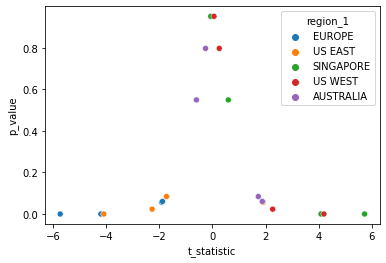

In [100]:
sns.scatterplot(x='t_statistic', y='p_value', data=regions_duration, hue='region_1')

As we can see, the deviation is most significant for `SINGAPORE` and `AUSTRALIA` regions compared to other regions. We can infer that match durations are significantly longer for players in the `AUSTRALIA` and `SINGAPORE` region than any other top region in the world, which could mean they opt for a more slow and calculated strategy compared to the rest of the world. Compared to that, the duration for `EUROPE` and `US EAST` regions is the lowest, hinting towards a faster play style.